# Milestone 2: Project proposal and initial analyses

We chose the **[CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/)**. This dataset contains 42,306 movie plot summaries extracted from Wikipedia + aligned metadata extracted from Freebase.

Using this dataset, we want to dive into the **drivers of an actor's success**. As the aspiration to become an actor is a dream for many, uncovering the factors or combinations of factors that contribute to an actor's accomplishment can provide valuable insights. 

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## 1. Exploration of the dataset

Many variables of the dataset are of interest: the type of roles actors take on, the countries in which they work, their ages at the beginning of their careers or at the time of the movie, their gender, etc.

### Movies metadata

In [30]:
movies = pd.read_table('./data/movie.metadata.tsv', header=None)
movies.columns = ['Wikipedia movie ID',
                  'Freebase movie ID',
                  'Movie name',
                  'Movie release date',
                  'Movie box office revenue',
                  'Movie runtime',
                  'Movie languages',
                  'Movie countries',
                  'Movie genres']


In [34]:
movies['Wikipedia movie ID'].count()

81741

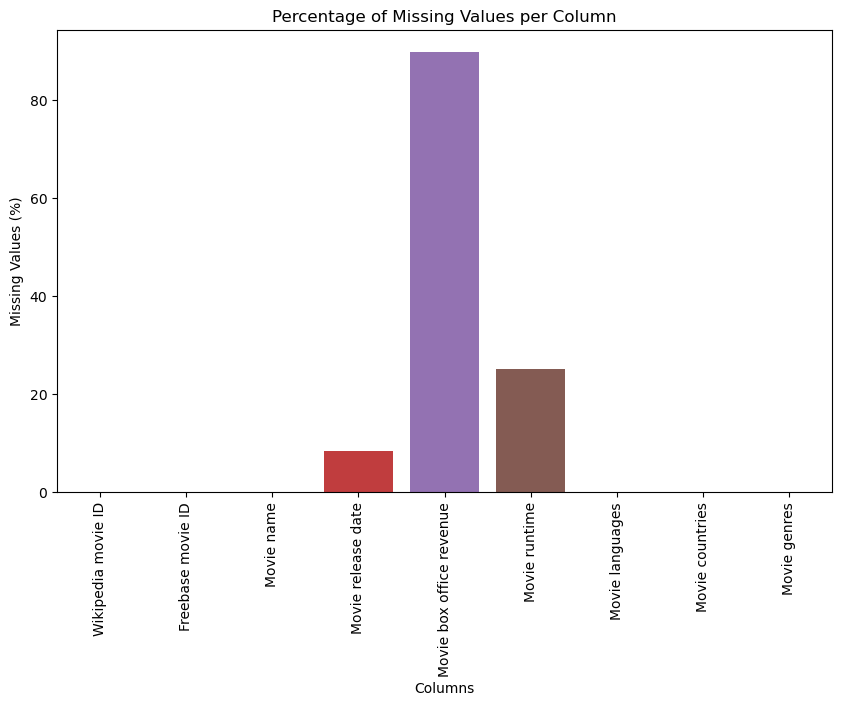

In [4]:
# Count missing values per column
missing_percent = (movies.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

# How will we deal with the large share of missing values for a key feature?

In [5]:
# Frequency of movie release
movies_release = movies['Movie release date'].dropna().copy()
movies_release = movies_release.reset_index()

movies_release.loc[:,'Release date'] = pd.to_datetime(movies_release['Movie release date'], format='mixed', errors='coerce') # convert release date into date format 

print('The first movie was released on {}.'.format(movies_release['Release date'].min()))
# movies_release['Relative release date'] = (movies_release['Release release date'] - movies_release['Release date'].min()).dt.days # and then into float

The first movie was released on 1888-01-01 00:00:00.


In [6]:
movies_release['Release date'].min() # Error? The function to_datetime itself doesn't accept dates that are too old

Timestamp('1888-01-01 00:00:00')

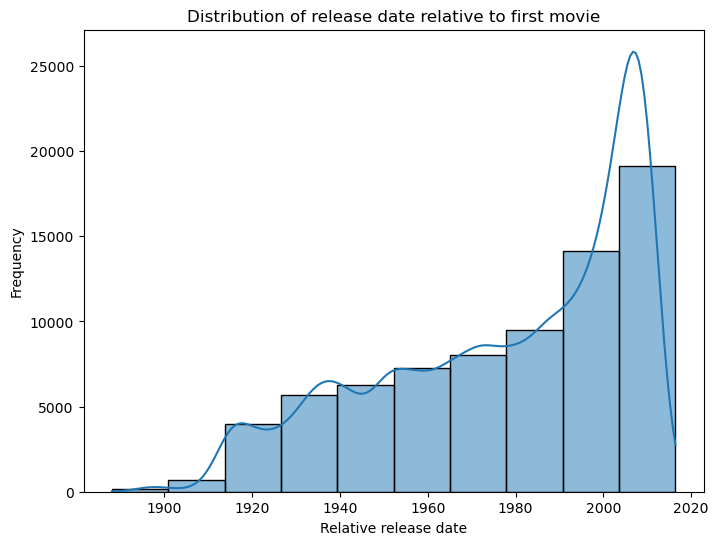

In [7]:
# Create a distribution plot using seaborn
plt.figure(figsize=(8, 6))
sns.histplot(data=movies_release, x='Release date', kde=True, bins=10)  # You can adjust the number of bins as needed
plt.xlabel('Relative release date')
plt.ylabel('Frequency')
plt.title('Distribution of release date relative to first movie')
plt.show()

In [115]:
import ast 

# Remove leading and trailing spaces, then parse the dictionaries
movies['Movie languages'] = movies['Movie languages'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie countries'] = movies['Movie countries'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie genres'] = movies['Movie genres'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})

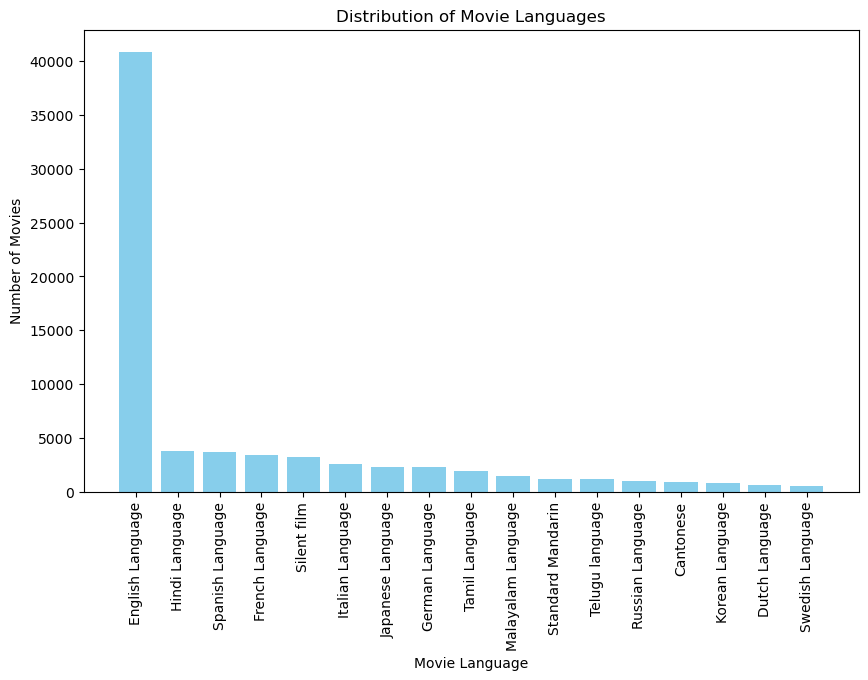

In [116]:
# Flatten the dictionaries and count language occurrences
language_counts = Counter(language for languages_dict in movies["Movie languages"] for language in languages_dict.values())

# Filter the language counts for readability
filtered_language_counts = {language: count for language, count in language_counts.items() if count > 500}
sorted_filtered_language_counts = dict(sorted(filtered_language_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
languages, counts = zip(*sorted_filtered_language_counts.items())
plt.bar(languages, counts, color='skyblue')
plt.xlabel('Movie Language')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Languages')
plt.xticks(rotation=90)  
plt.show()

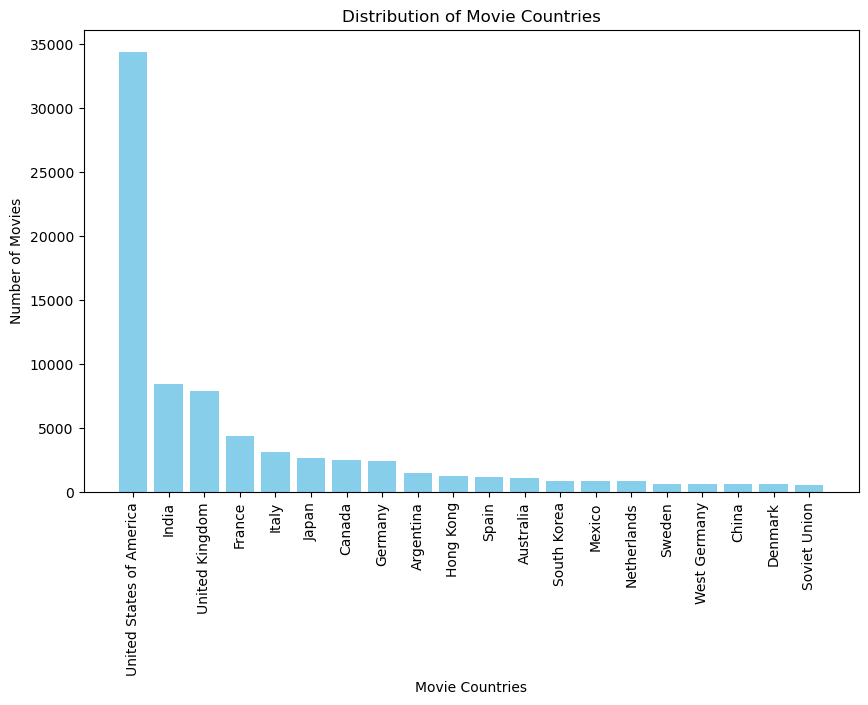

In [10]:
# Flatten the dictionaries and count countries occurrences
countries_counts = Counter(country for countries_dict in movies["Movie countries"] for country in countries_dict.values())

# Filter the language counts for readability
filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_filtered_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
countries, counts = zip(*sorted_filtered_countries_counts.items())
plt.bar(countries, counts, color='skyblue')
plt.xlabel('Movie Countries')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Countries')
plt.xticks(rotation=90)  
plt.show()

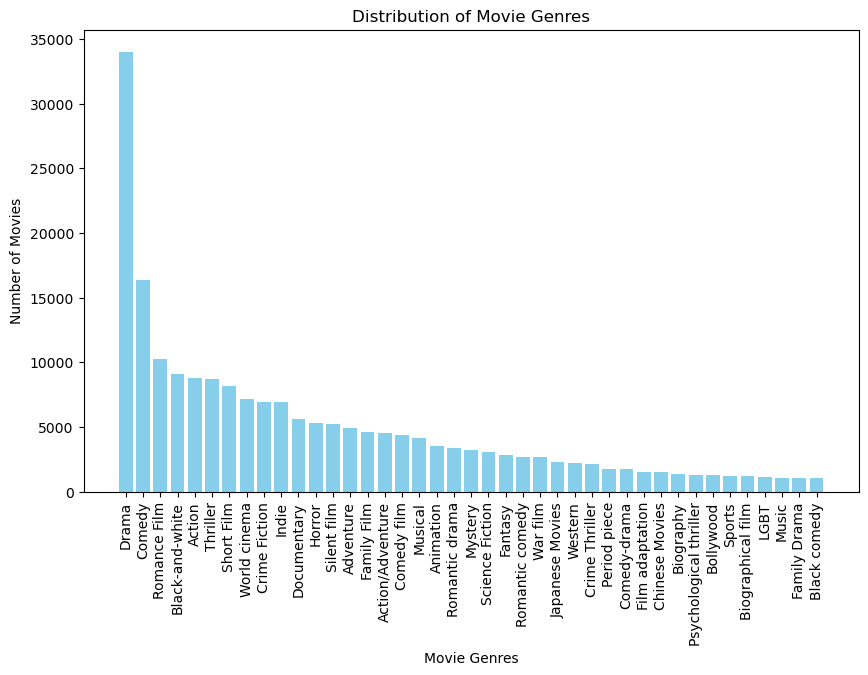

In [11]:
# Flatten the dictionaries and count countries occurrences
genres_counts = Counter(genre for genres_dict in movies["Movie genres"] for genre in genres_dict.values())

# Filter the language counts for readability
filtered_genres_counts = {genre: count for genre, count in genres_counts.items() if count > 1000}
sorted_filtered_genres_counts = dict(sorted(filtered_genres_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
genres, counts = zip(*sorted_filtered_genres_counts.items())
plt.bar(genres, counts, color='skyblue')
plt.xlabel('Movie Genres')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=90)
plt.show()

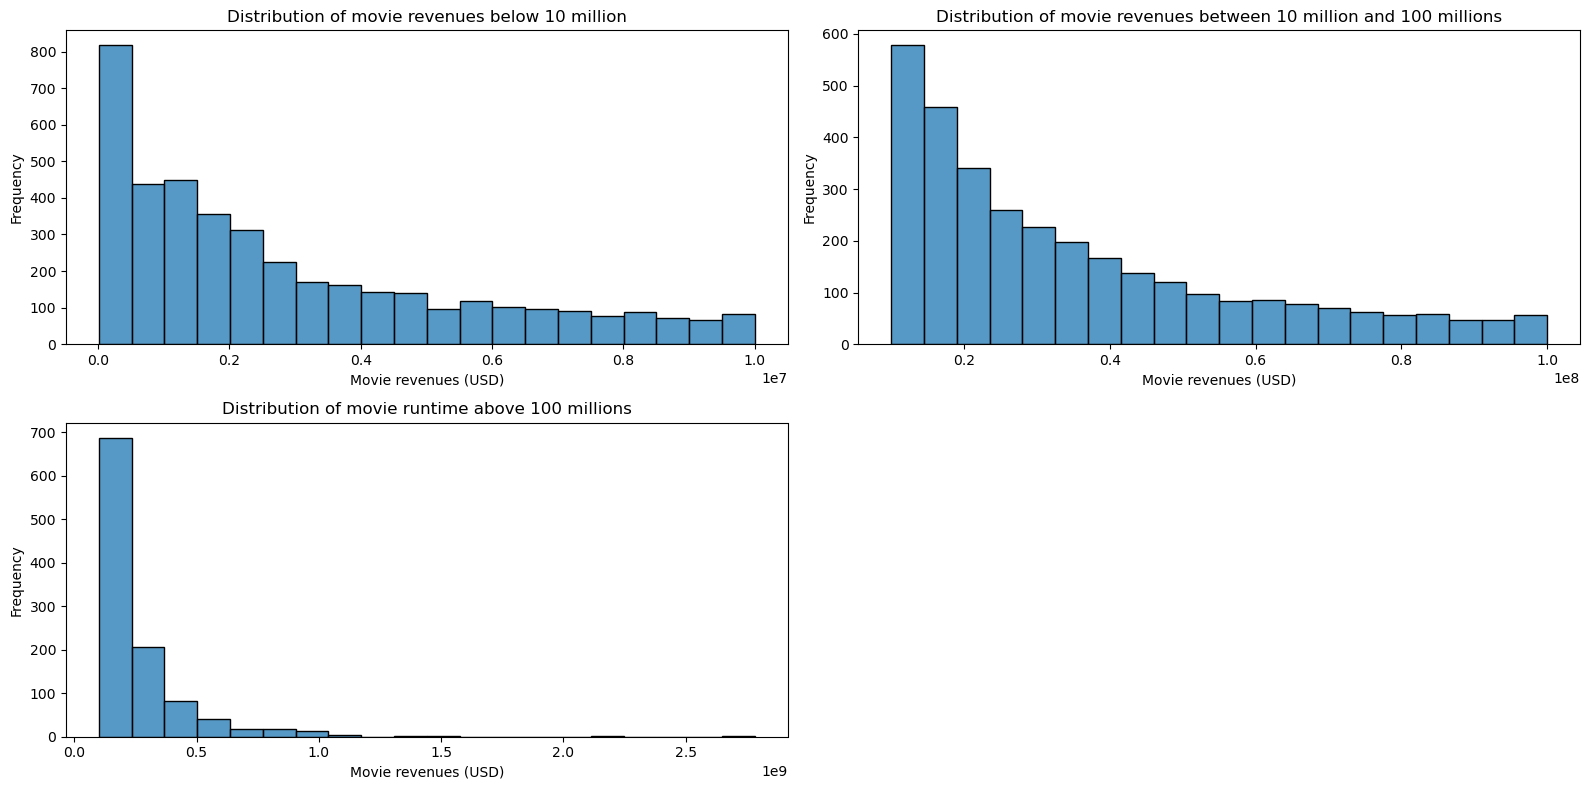

In [12]:
movies_revenues_low = movies['Movie box office revenue'][(movies['Movie box office revenue'] <= 10000000)].dropna()
movies_revenues = movies['Movie box office revenue'][(movies['Movie box office revenue'] <= 100000000) & (movies['Movie box office revenue'] > 10000000)].dropna()
movies_revenues_high = movies['Movie box office revenue'][(movies['Movie box office revenue'] > 100000000)].dropna()

# Create subplots with two plots side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Plot the first distribution 
sns.histplot(data=movies_revenues_low, kde=False, bins=20, ax=axes[0,0])
axes[0, 0].set_xlabel('Movie revenues (USD)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of movie revenues below 10 million')

# Plot the second distribution 
sns.histplot(data=movies_revenues, kde=False, bins=20, ax=axes[0, 1])
axes[0, 1].set_xlabel('Movie revenues (USD)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of movie revenues between 10 million and 100 millions')

# Plot the third distribution
sns.histplot(data=movies_revenues_high, kde=False, bins=20, ax=axes[1, 0])
axes[1, 0].set_xlabel('Movie revenues (USD)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of movie runtime above 100 millions')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

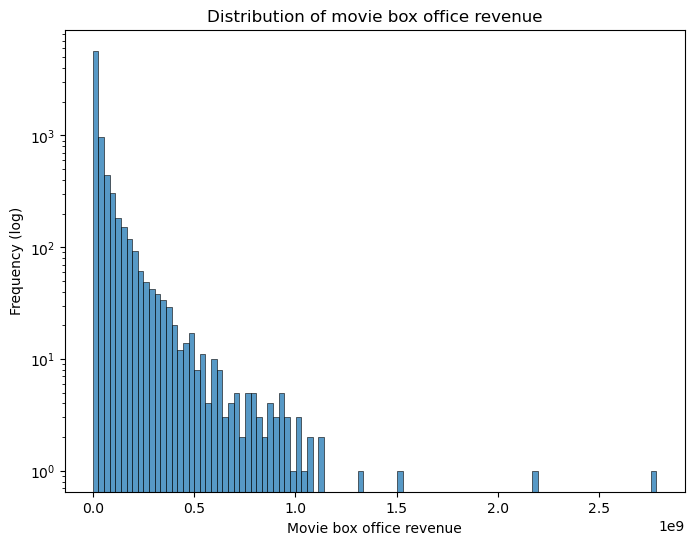

In [13]:
movies_revenues = movies['Movie box office revenue'].dropna().copy()

# Create a distribution plot using seaborn
plt.figure(figsize=(8, 6))
sns.histplot(data=movies_revenues, kde=False, bins=100)
plt.xlabel('Movie box office revenue')
plt.ylabel('Frequency (log)')
plt.title('Distribution of movie box office revenue')
plt.yscale("log")
plt.show()

In [14]:
movies['Movie runtime'].max() # some movies are very long

1079281.0

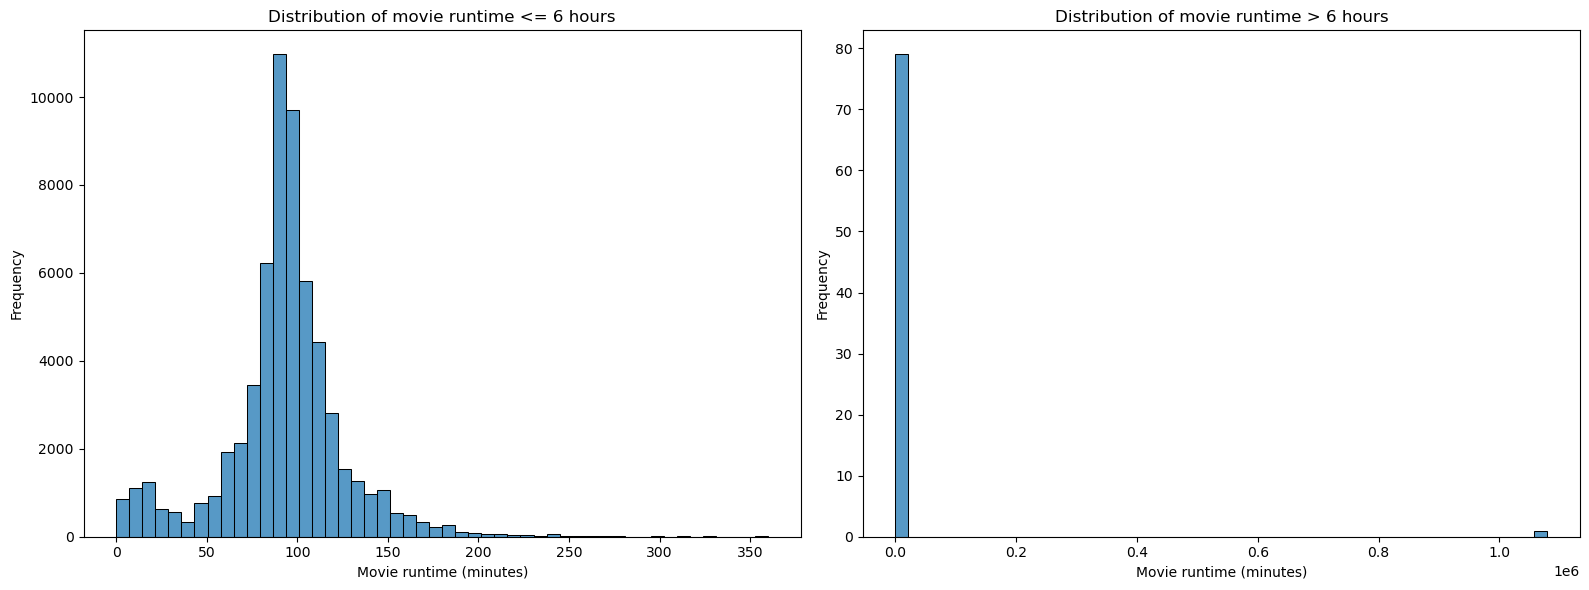

In [15]:
# we could also use a log scale but here we are interested in the absolute values of the extremes

movies_runtime = movies['Movie runtime'][(movies['Movie runtime'] <= 360)].dropna()
movies_runtime_long = movies['Movie runtime'][(movies['Movie runtime'] > 360)].dropna()

# Create subplots with two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first distribution (movie runtimes <= threshold)
sns.histplot(data=movies_runtime, kde=False, bins=50, ax=axes[0])
axes[0].set_xlabel('Movie runtime (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of movie runtime <= 6 hours')

# Plot the second distribution (movie runtimes > threshold)
sns.histplot(data=movies_runtime_long, kde=False, bins=50, ax=axes[1])
axes[1].set_xlabel('Movie runtime (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of movie runtime > 6 hours')

plt.tight_layout()
plt.show()

### Characters metadata

In [13]:
characters = pd.read_table('./data/character.metadata.tsv', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character name','Actor date of birth','Actor gender','Actor height (in meters)','Actor ethnicity (Freebase ID)','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
display(characters)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


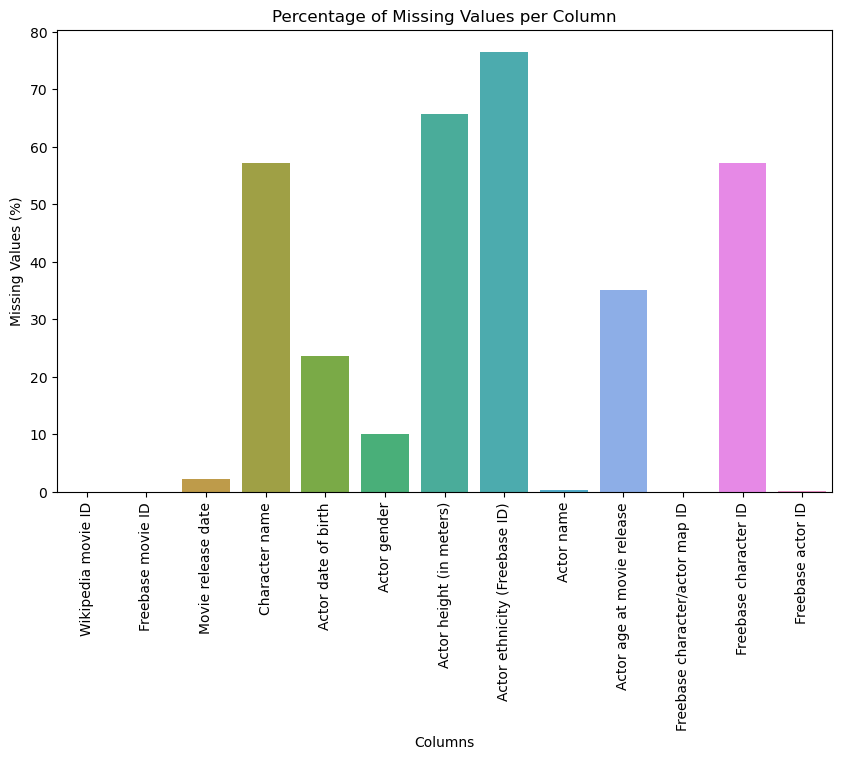

In [17]:
# Count missing values per column
missing_percent = (characters.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

In [18]:
# Get summary statistics
summary = characters.describe()

# Get the most frequent values
most_frequent = characters.mode().iloc[0]

# Get the number of missing values
missing_values = characters.isnull().sum()

# Combine the summary statistics into a single DataFrame
description = pd.concat([most_frequent, missing_values, summary.T], axis=1)
description.columns = ['Most Frequent', 'Missing', 'Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']

# Display the description
print(description)

                                Most Frequent  Missing     Count  \
Wikipedia movie ID                 27872371.0        0  450669.0   
Freebase movie ID                  /m/0cc8620        0       NaN   
Movie release date                       2008     9995       NaN   
Character name                         Doctor   257875       NaN   
Actor date of birth                1908-05-30   106145       NaN   
Actor gender                                M    45609       NaN   
Actor height (in meters)                 1.78   295845  154824.0   
Actor ethnicity (Freebase ID)      /m/0dryh9k   344611       NaN   
Actor name                          Mel Blanc     1228       NaN   
Actor age at movie release               31.0   158113  292556.0   
Freebase character/actor map ID    /m/01x30z5        0       NaN   
Freebase character ID              /m/0h577m2   257865       NaN   
Freebase actor ID                    /m/0c5vh      815       NaN   

                                         Mean  

In [29]:
characters[['Character name', 'Wikipedia movie ID']].query('`Wikipedia movie ID` == 31186339')


,Character name,Wikipedia movie ID
363228,Foxface,31186339
363229,Katniss Everdeen,31186339
363230,Peeta Mellark,31186339
363231,Effie Trinket,31186339
363232,Gale Hawthorne,31186339
363233,Haymitch Abernathy,31186339
363234,Clove,31186339
363235,Caesar Flickerman,31186339
363236,Primrose Everdeen,31186339
363237,President Snow,31186339


In [19]:
movies

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'}
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'}
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ..."


## 2. Complementary datasets

Other elements could be interesting but less straightforward to predict one's success, such as their relationships (are nepo-babies that favored?), studies (does studying theater actually help?), or wealth.

Moreover, peers recognition actors receive is a key element of success. We can complement our analysis with datasets on awards and on ratings to proxy it.

- [Oscars' winners and nominees](https://datahub.io/rufuspollock/oscars-nominees-and-winners)

In [19]:
oscars = pd.read_csv('~/ADA2023/Project/Data/oscar_awards.csv')
display(oscars)

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson
...,...,...,...,...
11053,2017,SCIENTIFIC AND TECHNICAL AWARD (Scientific and...,True,"To LEONARD CHAPMAN for the overall concept, de..."
11054,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,To JASON SMITH and JEFF WHITE for the original...
11055,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,"To JOE MANCEWICZ, MATT DERKSEN and HANS RIJPKE..."
11056,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,To ALEX POWELL for his contribution to the des...


In [20]:
oscars['category'].unique()

array(['ACTOR', 'ACTRESS', 'ART DIRECTION', 'CINEMATOGRAPHY',
       'DIRECTING (Comedy Picture)', 'DIRECTING (Dramatic Picture)',
       'ENGINEERING EFFECTS', 'OUTSTANDING PICTURE',
       'UNIQUE AND ARTISTIC PICTURE', 'WRITING (Adaptation)',
       'WRITING (Original Story)', 'WRITING (Title Writing)',
       'SPECIAL AWARD', 'DIRECTING', 'WRITING', 'OUTSTANDING PRODUCTION',
       'SOUND RECORDING', 'SCIENTIFIC OR TECHNICAL AWARD (Class I)',
       'SCIENTIFIC OR TECHNICAL AWARD (Class II)',
       'SCIENTIFIC OR TECHNICAL AWARD (Class III)',
       'SHORT SUBJECT (Cartoon)', 'SHORT SUBJECT (Comedy)',
       'SHORT SUBJECT (Novelty)', 'ASSISTANT DIRECTOR', 'FILM EDITING',
       'MUSIC (Scoring)', 'MUSIC (Song)', 'DANCE DIRECTION',
       'WRITING (Screenplay)', 'ACTOR IN A SUPPORTING ROLE',
       'ACTRESS IN A SUPPORTING ROLE', 'SHORT SUBJECT (Color)',
       'SHORT SUBJECT (One-reel)', 'SHORT SUBJECT (Two-reel)',
       'IRVING G. THALBERG MEMORIAL AWARD', 'MUSIC (Original Scor

In [21]:
actors_oscars = oscars[(oscars['category'].str.contains("ACTOR")) | (oscars['category'].str.contains("ACTRESS"))]
display(actors_oscars) 

# Until 1975, there was only one category for actors and one for actresses. 
# Nowadays, there are leading and supporting categories.

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson
...,...,...,...,...
10935,2017,ACTRESS IN A SUPPORTING ROLE,False,Mary J. Blige
10936,2017,ACTRESS IN A SUPPORTING ROLE,True,Allison Janney
10937,2017,ACTRESS IN A SUPPORTING ROLE,False,Lesley Manville
10938,2017,ACTRESS IN A SUPPORTING ROLE,False,Laurie Metcalf


In [22]:
# Group by 'year' and 'gender', and calculate the number of total observations and winners
actors_oscars['gender'] = np.where(actors_oscars['category'].str.contains("ACTOR"), 'Male','Female') # it is binary in the dataset

result = actors_oscars.groupby(['year', 'gender'])['winner'].agg(['count', 'sum']).reset_index()
result = result.rename(columns={'count': 'Total Observations', 'sum': 'Winners'})

# Pivot the table to have 'year' as columns and 'gender' as index
pivot_table = result.pivot_table(index='gender', columns='year', values=['Total Observations', 'Winners'], fill_value=0)

print(pivot_table)

       Total Observations                                               ...  \
year                 1927 1928 1929 1930 1931 1932 1934 1935 1936 1937  ...   
gender                                                                  ...   
Female                  3    6    6    5    3    3    4    6   10   10  ...   
Male                    2    5    6    5    3    3    3    5   10   10  ...   

       Winners                                               
year      2008 2009 2010 2011 2012 2013 2014 2015 2016 2017  
gender                                                       
Female       2    2    2    2    2    2    2    2    2    2  
Male         2    2    2    2    2    2    2    2    2    2  

[2 rows x 180 columns]


/var/folders/2d/tjq3n5693zgf146ztjtxnzr80000gp/T/ipykernel_29470/3295638862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_oscars['gender'] = np.where(actors_oscars['category'].str.contains("ACTOR"), 'Male','Female') # it is binary in the dataset


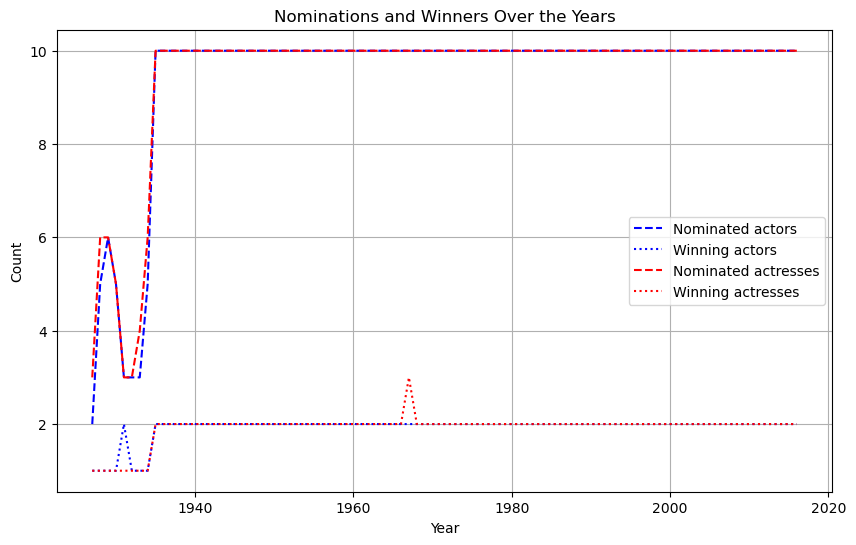

In [23]:
# Plot the lines
fig, ax = plt.subplots(figsize=(10, 6))

male_total_observations = pivot_table.loc['Male', ('Total Observations', slice(None))]
male_winners = pivot_table.loc['Male', ('Winners', slice(None))]
female_total_observations = pivot_table.loc['Female', ('Total Observations', slice(None))]
female_winners = pivot_table.loc['Female', ('Winners', slice(None))]
years = [n for n in range(1927,2017)]

plt.plot(years, male_total_observations, label='Nominated actors', color='blue', linestyle='--')
plt.plot(years, male_winners, label='Winning actors', color='blue', linestyle='dotted')
plt.plot(years, female_total_observations, label='Nominated actresses', color='red', linestyle='--')
plt.plot(years, female_winners, label='Winning actresses', color='red', linestyle='dotted')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Nominations and Winners Over the Years')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
characters_oscars = characters.merge(actors_oscars, left_on='Actor name', right_on='entity', how='left')

characters_oscars['entity'].isna().sum() # 418049
characters_oscars.shape[0] # 489192

print('There are {}% of Oscar nominees or winners in the movies dataset.'.format(round(100 - characters_oscars['entity'].isna().sum()/characters_oscars.shape[0] * 100,2)))

There are 14.31% of Oscar nominees or winners in the movies dataset.


## 3. Proposed outline

1. How to define success? \
Success in this context can be defined in numerous ways, including the duration of an actor's career, the quantity of lead roles they play, the cumulative profits of their movies. \
$\rightarrow$ Add data on income, ratings, more awards?

We aim to create a **success score**, which would be a combination of every success evaluation given by everybody in the group.

2. Predicting success with character metadata \
$\rightarrow$ How much do personal characteristics matter (age, height etc) \
$\rightarrow$ Add data on wealth, relationships, studies?

3. Predicting oscars with movies metadata \
$\rightarrow$ How much do movie characteristics matter (genre, country, plot, etc) \
$\rightarrow$ Text analysis of movie plots?

4. Identifying the driving factors of success \
$\rightarrow$ Strongest correlations/large predicting power in regressions?

5. Play with the results \
Imagine hypothetical scenario (or actor outside the dataset because they came up recently) and predict their success in an interactive manner

## 4. Initial analyses

### Predicting oscars with character metadata

In [25]:
## Prepare the features vector for training ##

# Choose the relevant features
actors_features = ['Movie release date', 'Actor gender', 'Actor age at movie release']

X = characters_oscars[actors_features].copy()

# Removing missing values, imputations don't make sense here
X_ = X[~(X.isna().any(axis=1))].copy()
len(X_[X_.isna().any(axis=1)])

# We need floats for training 

X_['Actor age at movie release'] = X_['Actor age at movie release'].astype('category')

X_.loc[:, 'release date'] = pd.to_datetime(X_['Movie release date'], format='mixed') # convert release date into date format 
X_['release date'] = (X_['release date'] - X_['release date'].min()).dt.days # and then into float

gender_mapping = {'F': 1, 'M': 2}
X_['Actor gender'] = X_['Actor gender'].map(gender_mapping) # Use a mapping to convert the 'gender' column to float

X_ = X_.drop('Movie release date', axis=1)

In [26]:
display(X_)

,Actor gender,Actor age at movie release,release date
0,1,42.0,33937
1,1,27.0,33937
2,2,32.0,33937
3,2,33.0,33937
4,1,23.0,33937
...,...,...,...
488433,2,38.0,30555
488434,2,38.0,30555
488435,1,34.0,30555
488438,2,27.0,30555


In [27]:
## Prepare the outcome vector for training ##

# We want integers as outcomes
outcome_mapping = {0: 'is nominated for an Oscar', 1: 'wins an Oscar', 2: 'gets nothing'}

characters_oscars.loc[characters_oscars['winner'].isna(), 'winner'] = 2 # missing values mean not winner nor nominated
y = characters_oscars['winner'].astype('int')

# We remove the same observations as for the features vector
y_ = y[~(X.isna().any(axis=1))]

In [28]:
display(y_)

0         2
1         2
2         2
3         2
4         2
         ..
488433    2
488434    2
488435    2
488438    2
488439    2
Name: winner, Length: 324454, dtype: int64

In [29]:
## Training ##

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.52      0.55      0.53      9595
           1       0.09      0.04      0.06      2664
           2       0.91      0.93      0.92     52632

    accuracy                           0.83     64891
   macro avg       0.51      0.51      0.50     64891
weighted avg       0.82      0.83      0.83     64891



In [32]:
predicted_label = model.predict([[1,43,30000]])[0]
outcome = outcome_mapping[predicted_label]

print('This actor/actress {}.'.format(outcome))

This actor/actress is nominated for an Oscar.


/Users/atoure/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Analysis of the Leading roles vs Secondary roles

Another way to assess the importance of an actor in a film would be to chack if the played role was for a leading or a secondary character.
To do so we're using the movie plot summary dataset and the idea is to quantify the occurence of a character name within the summary. 
We take the firt three characters having the most occurence in the movie plot summary as having a leading role and the other characters are classified as having a secondary role.
The results of the most occurences are stored in the dataframe main_character.

** note that sometimes the most occurent name in the plot is not always the first name of the character than the last name.

Then the idea is to put together the characters dataset and the main_characters


In [65]:
import numpy as np
import pandas as pd
import os
import gzip
from tqdm import tqdm
import xml.etree.ElementTree as ET

In [41]:
# read the movie plot summaries
movie_plots = pd.read_csv(
    './data/plot_summaries.txt',
    delimiter='\t',
    names=['id', 'plot']
)

In [42]:
movie_plots

,id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [46]:
from helpers import extract_character_names

extract_character=False

In [59]:
if extract_character==True:
    # Takes 18 min to run
    character_names=extract_character_names(movie_plots)
    character_names=pd.DataFrame(character_names, columns=['character_name', 'Movie_id'])
else:
    # The extracted names from the plots are stored in the following .csv file
    character_names=pd.read_csv('character_names_from_plots.csv')

In [61]:
character_names.head()

,character_name,Movie_id
0,Shlykov,23890098
1,Lyosha,23890098
2,Primrose,31186339
3,Everdeen,31186339
4,Katniss,31186339


In [63]:
# The number of occurences of the namees
occurences=character_names.value_counts().reset_index()
occurences.head()

,character_name,Movie_id,count
0,Timmy,22175264,136
1,Franklin,3926180,119
2,Danny,29680525,116
3,Soo,6283620,109
4,Napoleon,196923,99


In [92]:
#lets take the example of one particular movie "The Hunger games" to illustriate the pipeline
occurences[occurences['Movie_id']==31186339]

,character_name,Movie_id,count
6537,Katniss,31186339,18
24628,Peeta,31186339,8
51688,Haymitch,31186339,4
113813,Crane,31186339,2
176146,Thresh,31186339,1
182400,Primrose,31186339,1
200680,Flickerman,31186339,1
208777,Everdeen,31186339,1
219950,Abernathy,31186339,1
227492,Caesar,31186339,1


Here we can note that the extracted names contain the first name and second name of the same character Katniss and Everdeen as separate components 

In [67]:
# From the most frequent/ or emphasized names only 3 most frequent are selected (of course this choice can be discussed 
# as depending on the movies the main characters will be different)

main_characters=(occurences.groupby('Movie_id')).head(3)
main_characters.head()

,character_name,Movie_id,count
0,Timmy,22175264,136
1,Franklin,3926180,119
2,Danny,29680525,116
3,Soo,6283620,109
4,Napoleon,196923,99


In [93]:
# Example of Hunger games
main_characters[main_characters['Movie_id']==31186339]

,character_name,Movie_id,count
6537,Katniss,31186339,18
24628,Peeta,31186339,8
51688,Haymitch,31186339,4


### Merging with the character dataset

##### Number of character per movie analysis

Lets assess the averge number of characters per movie for the characters dataset

In [129]:
# we remove the missing values for character names
characters_filtered = characters.dropna(subset=['Character name'])


In [131]:
# create the dataframe
character_count=pd.DataFrame(characters_filtered.groupby('Wikipedia movie ID')['Character name'].count()).reset_index()
character_count.rename(columns={'Character name': 'Character number'}, inplace=True)
character_count.head()

,Wikipedia movie ID,Character number
0,3217,14
1,3746,15
2,3837,16
3,3947,15
4,4227,1


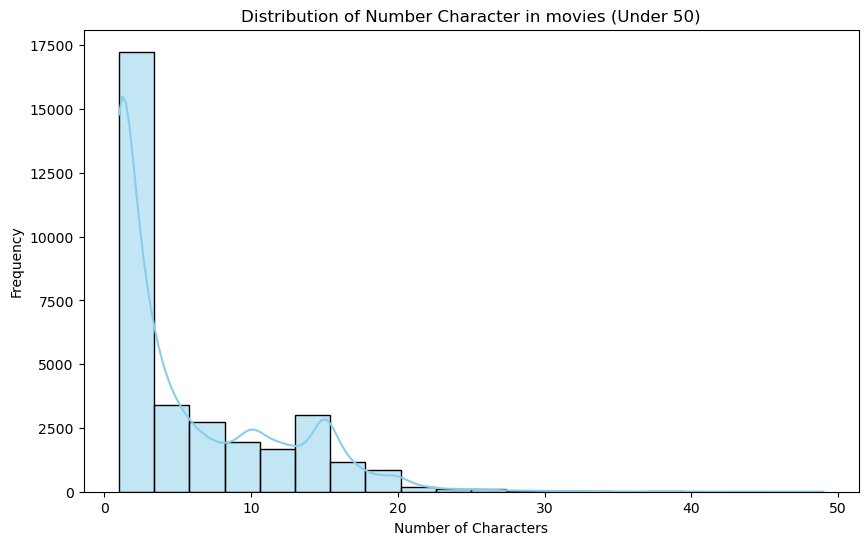

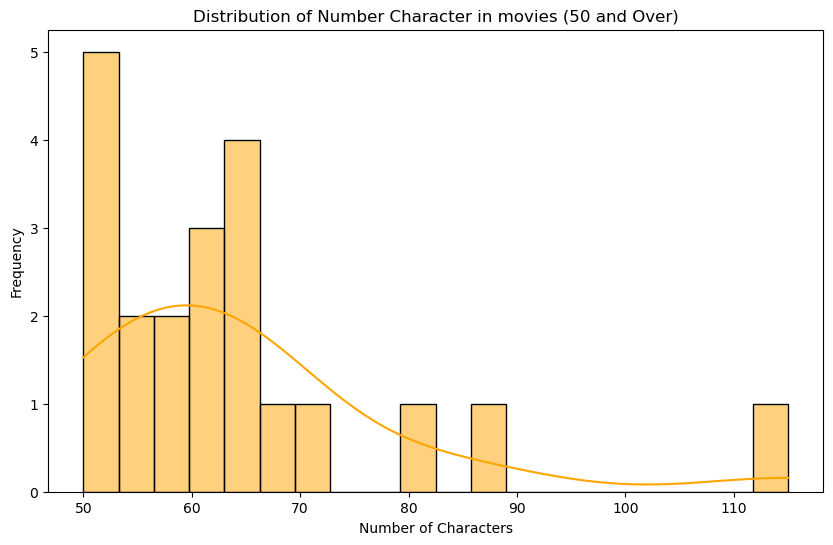

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming character_count is your data
under_50 = character_count[character_count['Character number'] < 50]
over_50 = character_count[character_count['Character number'] >= 50]

# Plot for movies with less then 50 characters
plt.figure(figsize=(10, 6))
sns.histplot(under_50['Character number'], bins=20, kde=True, color='skyblue')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Number Character in movies (Under 50)')
plt.show()

# Plot for movies which feature over 50 characters
plt.figure(figsize=(10, 6))
sns.histplot(over_50['Character number'], bins=20, kde=True, color='orange')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Number Character in movies (50 and Over)')
plt.show()

In [134]:
character_count.describe()

,Wikipedia movie ID,Character number
count,3.257100e+04,32571.000000
mean,1.367490e+07,5.919192
std,1.049220e+07,6.054013
min,3.217000e+03,1.000000
25%,3.886514e+06,1.000000
50%,1.153411e+07,3.000000
75%,2.267748e+07,10.000000
max,3.750192e+07,115.000000


The mean character number per movie is approximatively 6. 

#### Merge

The content in the 'character name' column exhibits significant variability. While some entries represent the actual full names of characters, others encompass character descriptions or denote the type of role they embody

In [139]:
characters_filtered['Character name']

0                           Akooshay
1         Lieutenant Melanie Ballard
2                Desolation Williams
3                 Sgt Jericho Butler
4                    Bashira Kincaid
                     ...            
450661            UN Spacy Commander
450662                   Silvie Gena
450663                       Exegran
450664                        Elensh
450665                        Hibiki
Name: Character name, Length: 192794, dtype: object

The merging process between the main character dataframe and the filtered characters dataframe involves checking whether the names of the main characters appear in the 'character name' column of the characters dataframe.

In [142]:
intermediate_merge=pd.merge(main_characters, characters_filtered, left_on='Movie_id', right_on='Wikipedia movie ID')
intermediate_merge.head()

,character_name,Movie_id,count,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Marcellus Gallio,1925-11-10,M,1.780,/m/06gbnc,Richard Burton,27.0,/m/0k69rx,/m/02nwqcn,/m/0cg9f
1,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Apostle Peter,1909-08-25,M,NaN,NaN,Michael Rennie,43.0,/m/02vd6_v,/m/04l4lz_,/m/017tk3
2,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Demetrius,1913-01-29,M,1.880,NaN,Victor Mature,39.0,/m/02vbdrn,/m/075nf96,/m/029135
3,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Caligula,1930-04-14,M,NaN,NaN,Jay Robinson,22.0,/m/03jsrph,/m/075nf9f,/m/0ksbq2
4,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Pontius Pilate,1917-06-18,M,1.854,NaN,Richard Boone,35.0,/m/042h1f0,/m/042gzwn,/m/03c2b1


In [172]:
# check if the main character name appears in the character name column
intermediate_merge['appears'] = intermediate_merge.apply(lambda row: row['character_name'] in row['Character name'], axis=1)
intermediate_merge.rename(columns={'character_name':'main_character_name'}, inplace=True)

In [173]:
intermediate_merge.head()

,main_character_name,Movie_id,count,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,appears
0,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Marcellus Gallio,1925-11-10,M,1.780,/m/06gbnc,Richard Burton,27.0,/m/0k69rx,/m/02nwqcn,/m/0cg9f,True
1,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Apostle Peter,1909-08-25,M,NaN,NaN,Michael Rennie,43.0,/m/02vd6_v,/m/04l4lz_,/m/017tk3,False
2,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Demetrius,1913-01-29,M,1.880,NaN,Victor Mature,39.0,/m/02vbdrn,/m/075nf96,/m/029135,False
3,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Caligula,1930-04-14,M,NaN,NaN,Jay Robinson,22.0,/m/03jsrph,/m/075nf9f,/m/0ksbq2,False
4,Marcellus,7548602,96,7548602,/m/0kvb6p,1953,Pontius Pilate,1917-06-18,M,1.854,NaN,Richard Boone,35.0,/m/042h1f0,/m/042gzwn,/m/03c2b1,False


The intermediate_merge dataframe displays the test results for the appearance of the main character names in the 'character name' column. For a given movie this appeaence is tested for three main character names. Consequently, secondary characters can be identified as those who have consistently obtained a 'False' score in the 'appear' column for all three main characters within a given movie.

In [174]:
leading_characters=intermediate_merge[intermediate_merge['appears']].drop(['Movie_id'], axis=1)
leading_characters.head()

,main_character_name,count,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,appears
0,Marcellus,96,7548602,/m/0kvb6p,1953,Marcellus Gallio,1925-11-10,M,1.78,/m/06gbnc,Richard Burton,27.0,/m/0k69rx,/m/02nwqcn,/m/0cg9f,True
16,Demetrius,28,7548602,/m/0kvb6p,1953,Demetrius,1913-01-29,M,1.88,NaN,Victor Mature,39.0,/m/02vbdrn,/m/075nf96,/m/029135,True
21,Ned,94,28173585,/m/0cmbmct,2011-01-22,Ned,1969-04-06,M,1.78,/m/041rx,Paul Rudd,41.0,/m/0gm1jpw,/m/0gvdf02,/m/032w8h,True
38,Miranda,23,28173585,/m/0cmbmct,2011-01-22,Miranda,1974-02-10,F,1.65,NaN,Elizabeth Banks,36.0,/m/0gm270g,/m/0gvdd_2,/m/0716t2,True
55,Natalie,20,28173585,/m/0cmbmct,2011-01-22,Natalie,1980-01-17,F,1.66,/m/033tf_,Zooey Deschanel,31.0,/m/0gm27sp,/m/0gvdd_b,/m/03rl84,True


In [175]:
secondary=intermediate_merge[intermediate_merge['appears']== False].drop(['Movie_id'], axis=1)

In [176]:
secondary_per_movie=secondary.groupby('Wikipedia movie ID')
secondary_per_movie=pd.DataFrame(secondary_per_movie[['Character name', 'Actor name']].value_counts())
secondary_characters=secondary_per_movie[secondary_per_movie['count']==3].reset_index()

In [177]:
secondary_per_movie

count
Wikipedia movie ID Character name   Actor name                  
3217               Ash Williams     Bruce Campbell             3
                   Blacksmith       Timothy Patrick Quill      3
                   Possessed Witch  Patricia Tallman           3
                   S-Mart Clerk     Ted Raimi                  3
                   Cowardly Warrior Ted Raimi                  3
...                                                          ...
36956792           Old Angus        Brian Cox                  2
                   Angus MacMorrow  Alexander Nathan Etel      2
37478048           Ajay             Akkineni Nagarjuna         3
37501922           Craig Murphy     Alexis Arquette            3
                   John Hunter      Luke Perry                 2

[134361 rows x 1 columns]

In [178]:
secondary_characters.drop(['count'], axis=1)

,Wikipedia movie ID,Character name,Actor name
0,3217,Ash Williams,Bruce Campbell
1,3217,Blacksmith,Timothy Patrick Quill
2,3217,Possessed Witch,Patricia Tallman
3,3217,S-Mart Clerk,Ted Raimi
4,3217,Cowardly Warrior,Ted Raimi
...,...,...,...
89645,36956792,Female Tourist,Megan Katherine
89646,36956792,Corporal Grubbs,Edward Newborn
89647,36956792,Clyde,William Johnson
89648,37478048,Ajay,Akkineni Nagarjuna


In [186]:
# this analysis can be compromised by the following example:

hunger_games=leading_characters[leading_characters['Wikipedia movie ID']==31186339]
hunger_games[['main_character_name', 'Character name', 'Actor name']]

,main_character_name,Character name,Actor name
98802,Katniss,Katniss Everdeen,Jennifer Lawrence
98820,Katniss,Katniss' Father,Phillip Troy Linger
98824,Peeta,Peeta Mellark,Josh Hutcherson
98848,Haymitch,Haymitch Abernathy,Woody Harrelson


Observing the results, it is noted that the main character name also appears in the entry for 'Katniss' Father,' despite him not being a primary character. Consequently, it is evident that this approach requires refinement for achieving the milestone.

### Ideas for further analysis:

After categorizing characters and their associated actors into main and secondary roles, we can perform some additional analysis to gain deeper insights into how success works iin the film industry. Here are some additional analysis ideas:

1. **Oscar Success and Main Roles:**
   Explore whether winning an Oscar is correlated with playing the main character in a movie. Does holding a leading role increase an actor's chances of receiving this prestigious award?

2. **Popularity and Main Roles:**
   Investigate whether actors who consistently portray significant roles in movies tend to be more popular. Are those who predominantly take on leading roles more likely to gain popularity among the audience?

3. **Success from Secondary Roles:**
   Explore instances where actors in secondary roles achieve significant success. Can a supporting character contribute to an actor's overall success, and are there examples where a secondary role leads to substantial recognition?

4. **Talent and Non-Leading Roles:**
   Assess whether an actor's talent is still evident when they are not in a leading role. Do audiences recognize and appreciate an actor's skill even when they are not at the forefront of the narrative?

5. **Selection of Leading Roles:**
   Investigate the criteria and considerations in the selection of leading roles for movies. What factors influence casting decisions, and how do filmmakers determine who should play the main character in a given film?

By exploring these aspects, we can gain a comprehensive understanding of the dynamics between roles, actor success, and audience reception in the film industry.

# Personna analysis

A comprehensive methodology for evaluating an actor's performance and success entails examining the breadth of personas and character types they can authentically embody. A compelling strategy for conducting this analysis is inspired by the research paper titled "Learning Latent Personas of Film Characters," authored by David Bamman, Brendan O’Connor, and Noah A. Smit.

The proposed approach suggests employing the Dirichlet persona model to extract personas from agent verbs, patient verbs, and attributes associated with a character. The Dirichlet model utilizes soft clustering on words, creating topics based on contextual similarity. This soft clustering is then extended from topics to personas, allowing subsequent hard clustering from characters to personas.

Assigning a specific persona type to a character enables the examination of the range of personas portrayed by the actor. This examination involves assessing the number of persona clusters in which the actor has taken on a role. Subsequently, correlations can be established between the actor's success score and the diversity of personas they have convincingly depicted.

This methodology offers a nuanced perspective on an actor's versatility and its potential influence on their overall success within the industry. It provides a detailed understanding of how an actor's ability to embody diverse personas contributes to their achievements in the film industry.